In [193]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 28 14:30:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |   9198MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [194]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.54 s (started: 2022-01-28 14:30:51 +00:00)


In [195]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 3.18 ms (started: 2022-01-28 14:30:53 +00:00)


In [196]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

time: 13.8 ms (started: 2022-01-28 14:30:53 +00:00)


# Variables

## Paths

In [197]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220128_14H30/
time: 7.74 ms (started: 2022-01-28 14:30:53 +00:00)


## Other

In [198]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000 # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 10
# learing rate 
learning_rate = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 32 #32
# base model trainable 
base_model_trainable = False

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 8.17 ms (started: 2022-01-28 14:30:53 +00:00)


# Load & filter data

## Unzip images

In [199]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 6.42 ms (started: 2022-01-28 14:30:53 +00:00)


In [200]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.95 ms (started: 2022-01-28 14:30:53 +00:00)


## File_path df

In [201]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 1.86 s (started: 2022-01-28 14:30:53 +00:00)


In [202]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 2.8 ms (started: 2022-01-28 14:30:55 +00:00)


In [203]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 310 ms (started: 2022-01-28 14:30:55 +00:00)


In [204]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 157 ms (started: 2022-01-28 14:30:56 +00:00)


In [205]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 46.4 ms (started: 2022-01-28 14:30:56 +00:00)


In [206]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 61.2 ms (started: 2022-01-28 14:30:56 +00:00)


In [207]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 115 ms (started: 2022-01-28 14:30:56 +00:00)


In [208]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 20.4 ms (started: 2022-01-28 14:30:56 +00:00)


In [209]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 30.1 ms (started: 2022-01-28 14:30:56 +00:00)


In [210]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 1.21 ms (started: 2022-01-28 14:30:56 +00:00)


In [211]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 65.5 ms (started: 2022-01-28 14:30:56 +00:00)


In [212]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.33 ms (started: 2022-01-28 14:30:56 +00:00)


In [213]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 21.8 ms (started: 2022-01-28 14:30:56 +00:00)


In [214]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.53 ms (started: 2022-01-28 14:30:56 +00:00)


In [215]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 18.3 ms (started: 2022-01-28 14:30:56 +00:00)


In [216]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{0: 'Russulaceae',
 1: 'Boletaceae',
 2: 'Strophariaceae',
 3: 'Tricholomataceae',
 4: 'Amanitaceae',
 5: 'Agaricaceae',
 6: 'Cortinariaceae'}

time: 9.2 ms (started: 2022-01-28 14:30:56 +00:00)


## Train/test split

In [217]:
#train/test 
X_train_path, X_test_path, y_train, y_test = train_test_split(df['drive_file_path'], df['label'], train_size=0.8, stratify =df['label'], random_state=random_seed)
print(X_train_path.shape,X_test_path.shape)

(4000,) (1000,)
time: 10.1 ms (started: 2022-01-28 14:30:56 +00:00)


In [218]:
# /!\ ONE IMAGE PER CLASS
if one_image_per_class_only:
  # one im per class for debug to test if predict all classes 
  X_train_path, X_test_path, y_train, y_test = train_test_split(df['drive_file_path'], df['label'], train_size=classes_count, test_size=classes_count, stratify =df['label'], random_state=random_seed)
  # print less claases , on doit voir une fois chacune des classes 
  print(X_train_path.shape,X_test_path.shape)
  print(df['label'][X_train_path.index].sort_values())

time: 1.89 ms (started: 2022-01-28 14:30:56 +00:00)


In [219]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(y_train),y =y_train)
class_weights = dict(enumerate(class_weights))

time: 4.63 ms (started: 2022-01-28 14:30:56 +00:00)


In [220]:
# RECUPERER POSITION DANS LA LISTE 

time: 478 µs (started: 2022-01-28 14:30:56 +00:00)


### Plot few images

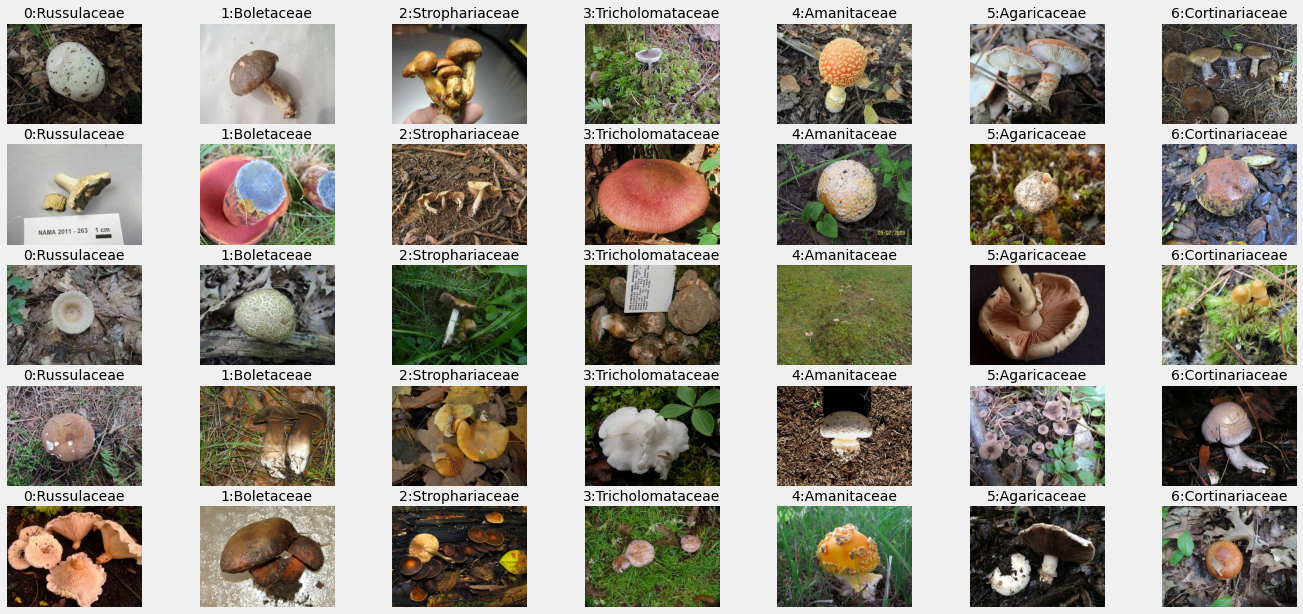

time: 5.53 s (started: 2022-01-28 16:09:43 +00:00)


In [235]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
# generate a df train from idx
train_idx = X_train_path.index
df_train = df.loc[train_idx]
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# list to catch X_train postion to plot tf dataset
im_position = []
# plot
plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(X_train_path[idx])
  plt.imshow(im)
  label = str(y_train[idx]) + ':' + dict_label[y_train[idx]]
  im_position.append(y_train.index.get_loc(idx)) # position dans le array y_train
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
  fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

## TF dataset

In [222]:
# load dataset 
@tf.function
def load_image(file_path, resize=resol):
    im = tf.io.read_file(file_path)
    im = tf.image.decode_jpeg(im, channels=3)
    im = tf.image.resize(im, resize)  # utile only if differentes resolution
    return im

# train 
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.map(lambda x, y : [load_image(x,resol), y], num_parallel_calls=-1).batch(batch_size)
# test 
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test = dataset_test.map(lambda x, y : [load_image(x,resol), y], num_parallel_calls=-1).batch(batch_size)

time: 234 ms (started: 2022-01-28 14:30:59 +00:00)


Resolution is: (240, 320)


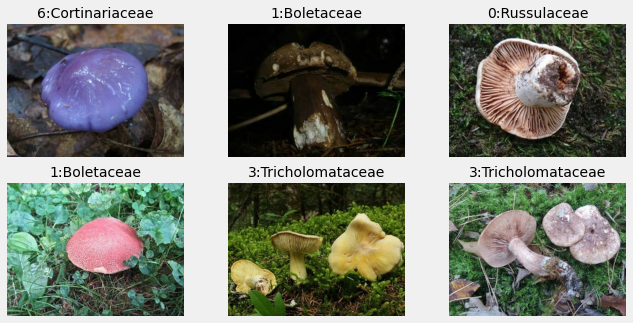

time: 527 ms (started: 2022-01-28 14:30:59 +00:00)


In [223]:
# VOIR COMMENT ON REROUVE LES IMAGES PLOTTER EN X TRAIN 
# check images in the tf train dataset after resize
image_batch,label_batch = next(iter(dataset_train))
fig = plt.figure(figsize=(10,5))
# On décode le fichier
for i in range(min(6,len(X_train_path))):
  ax = plt.subplot(2,3,i+1)
  im = image_batch[i].numpy()
  im = np.uint8(im) # imshow wants as input 0-1 float or 0-255 int. Since your image has values in the range 0-255 float, if you don't put np.uint8 it automatically clips them in integer
  plt.imshow(im)
  label = str(y_train.values[i]) + ':' + dict_label[y_train.values[i]]
  plt.title(label,size = 14)
  plt.axis('off');
print('Resolution is: {}'.format(resol))
fig.savefig(export_dir + str(resol) + '_example.jpeg' )

# Fonctions

## Build models

In [224]:
# model 
def define_model(model_name,model):
  base_model = model
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
  dropout1 = tf.keras.layers.Dropout(0.3)
  dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')
  dropout2 = tf.keras.layers.Dropout(0.5)
  prediction_layer =  Dense(units = classes_count, activation = 'softmax')


  for layer in base_model.layers:
      layer.trainable = base_model_trainable

  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense1, 
    dropout1,
    dense2,
    dropout2,
    prediction_layer
  ],
  name = model_name)
  return model



time: 18.8 ms (started: 2022-01-28 14:31:00 +00:00)


## Plot history

In [225]:
def plot_history(history):
  train_acc_model = training_history_model.history['accuracy']
  val_acc_model = training_history_model.history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history.history['loss'])), history.history['loss'], '-o', label = "training")
  plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.8)
  plt.close()
  return fig

time: 31.2 ms (started: 2022-01-28 14:31:00 +00:00)


## Confusion matrix 

In [226]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 36 ms (started: 2022-01-28 14:31:00 +00:00)


# Fit & assess

## Dict of models 

In [227]:
model_dict = {
    'VGG16' : tf.keras.applications.VGG16(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False), 
    'VGG19' : tf.keras.applications.VGG16(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False), 
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'EFB3' : tf.keras.applications.EfficientNetB3(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'resnet50' : tf.keras.applications.resnet50.ResNet50(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV2': tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Small': tf.keras.applications.MobileNetV3Small(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),    
    'InceptionResNetV2': tf.keras.applications.InceptionResNetV2(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'InceptionV3': tf.keras.applications.InceptionV3(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNet': tf.keras.applications.MobileNet(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'Xception': tf.keras.applications.Xception(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

time: 31.5 s (started: 2022-01-28 14:31:00 +00:00)


##Loop

In [228]:
# loop 
print('Files exported in :{}'.format(str(export_dir)))
print('*'*120)
for model_name, model in model_dict.items():
  model = define_model(model_name,model)
  model_infos= {}
  i = 0 # counter pour dict key 
  tic = time.time() # timer start
  # csv start path infos 
  pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(X_train_path)) + '_images'
  print(pathinfos)
  # Compilation
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']) 
  # Entraînement
  training_history_model = model.fit(dataset_train,epochs=epochs,validation_data=dataset_test,class_weight=class_weights) 
  # timer end 
  tac = time.time()
  time_to_fit = tic - tac
  print('il faut {}min pour construire le model'.format(round(time_to_fit/60,3)))
  train_size= tf.data.experimental.cardinality(dataset_train).numpy()*batch_size
  # export training infos  
  model_infos[i] = [resol,family_number,train_size,model.name,time_to_fit] 
  model_infos_df = pd.DataFrame.from_dict(model_infos, orient='index',
                                          columns = ['res','number_of_family','number_of_training_images','model','time_to_fit']). \
                                          to_csv(export_dir +pathinfos + '_model_infos.csv')
  dict_label_df.to_csv(export_dir + pathinfos + '_dict_label.csv') 
  # save history 
  hist_df = pd.DataFrame(training_history_model.history)
  hist_df.to_csv(export_dir + pathinfos + '_history.csv')
  training_history_fig = plot_history(training_history_model)
  display(training_history_fig)
  # save fig 
  training_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg' )
    

  #assess performances 
  test_pred_class = model.predict(dataset_test ).argmax(axis = 1) # predictions test
  y_test_class = np.concatenate([y for x, y in dataset_test], axis=0) # true label 
  print(metrics.classification_report(y_test_class, test_pred_class))
  # save report
  report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
  report = pd.DataFrame(report).transpose()
  report_path = export_dir + pathinfos + '_classification report.csv'
  report.to_csv(report_path)
  # conf matrix  
  classes = df['gbif_info.family'].nunique()  # classes
  # label and count for legend 
  unique, counts = np.unique(y_test_class, return_counts=True)
  test_dict_label = pd.DataFrame(zip(unique, counts), columns=['label','y_test_count'])
  test_dict_label = dict_label_df.merge(test_dict_label,on='label')
  test_dict_label = test_dict_label.drop(['size'], axis=1)
  # plot 
  conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
  display(conf_matrix_fig)
  # save fig 
  conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
  print('*'*120)
  print('*'*120)

Output hidden; open in https://colab.research.google.com to view.

# Compare models

## Load data

In [237]:
# irectory with report manually define 
perf_report_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/DL Model comparison'
print('perf_report_dir  is {}'.format(perf_report_dir ))

perf_report_dir  is /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/DL Model comparison
time: 1.76 ms (started: 2022-01-28 16:30:50 +00:00)


### Score 

In [238]:
# get classif reports
classif_reports = next(os.walk(perf_report_dir), (None, None, []))[2]  # [] if no file
classif_reports = [perf_report_dir + '/' +  report for report in classif_reports if 'classification report' in report]

time: 5.88 ms (started: 2022-01-28 16:31:11 +00:00)


In [258]:
# create summary df from classif reports 
accuracys = []
avg_f1s = []
weighted_f1 = []
models = []

for report_csv in classif_reports:
    rep_df = pd.read_csv(report_csv, index_col = 'Unnamed: 0')
    # exttract model name 
    model_name = re.findall('[a-zA-Z0-9]+_', report_csv )[0].replace("_","")
    models.append(model_name)
    # metric 
    accuracys.append(rep_df.loc['accuracy','f1-score'])
    avg_f1s.append(rep_df.loc['macro avg','f1-score'])
    weighted_f1.append(rep_df.loc['weighted avg','f1-score'])
# generate df
classif_summary_df = pd.DataFrame(list(zip(models,accuracys,avg_f1s,weighted_f1)),
            columns = ['model','accuracy','avg_f1','wgt_avg_f1'])
classif_summary_df

,model,accuracy,avg_f1,wgt_avg_f1
0,VGG16,0.521,0.511024,0.515501
1,VGG19,0.495,0.478445,0.482609
2,EFB1,0.590,0.577584,0.583805
3,EFB3,0.572,0.553524,0.560605
4,resnet50,0.544,0.531289,0.540013
5,MobileNetV2,0.258,0.227579,0.231015
6,MobileNetV3Large,0.585,0.577916,0.582798
7,MobileNetV3Small,0.568,0.555079,0.563941
8,InceptionResNetV2,0.172,0.044293,0.052053
9,InceptionV3,0.141,0.045552,0.043165


time: 86.7 ms (started: 2022-01-28 16:40:44 +00:00)


### Time 

In [265]:
# extract times info 
model_infos_reports = next(os.walk(perf_report_dir), (None, None, []))[2]  # [] if no file
model_infos_reports = [perf_report_dir + '/' +  report for report in model_infos_reports  if 'model_infos' in report]

time: 16.4 ms (started: 2022-01-28 16:44:03 +00:00)


In [284]:
models = []
fit_duration = []

for report_csv in model_infos_reports:
    rep_df = pd.read_csv(report_csv, index_col = 'Unnamed: 0')
    # exttract model name 
    models.append(rep_df['model'].values[0])
    fit_duration.append(-rep_df['time_to_fit'].values[0])
# generate df
fit_duration_df = pd.DataFrame(list(zip(models,fit_duration)),
            columns = ['model','fit_duration'])
fit_duration_df

,model,fit_duration
0,VGG16,365.800775
1,VGG19,354.062199
2,EFB1,232.916816
3,EFB3,340.058512
4,resnet50,361.118957
5,MobileNetV2,124.560065
6,MobileNetV3Large,116.667046
7,MobileNetV3Small,94.034329
8,InceptionResNetV2,615.793150
9,InceptionV3,189.770770


time: 83.3 ms (started: 2022-01-28 16:55:51 +00:00)


## Final summary

In [285]:
# join 
perf_summary = classif_summary_df.merge(fit_duration_df).sort_values(by=['wgt_avg_f1'], ascending=False)
perf_summary

,model,accuracy,avg_f1,wgt_avg_f1,fit_duration
2,EFB1,0.590,0.577584,0.583805,232.916816
6,MobileNetV3Large,0.585,0.577916,0.582798,116.667046
7,MobileNetV3Small,0.568,0.555079,0.563941,94.034329
3,EFB3,0.572,0.553524,0.560605,340.058512
4,resnet50,0.544,0.531289,0.540013,361.118957
0,VGG16,0.521,0.511024,0.515501,365.800775
1,VGG19,0.495,0.478445,0.482609,354.062199
5,MobileNetV2,0.258,0.227579,0.231015,124.560065
10,MobileNet,0.245,0.198531,0.202650,99.927362
11,Xception,0.232,0.191402,0.196873,385.728155


time: 72.1 ms (started: 2022-01-28 16:55:53 +00:00)


## Plots

In [286]:
def plot_perf(df,metric):
    fig = plt.figure(figsize=(20,5))
    sns.lineplot(x=df['model'], y=df[metric], label='')
    plt.xlabel('model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.title('{} = f(model)'.format(metric))
    plt.close();
    return fig

time: 6.91 ms (started: 2022-01-28 16:55:54 +00:00)


--------------------------------------------------accuracy--------------------------------------------------


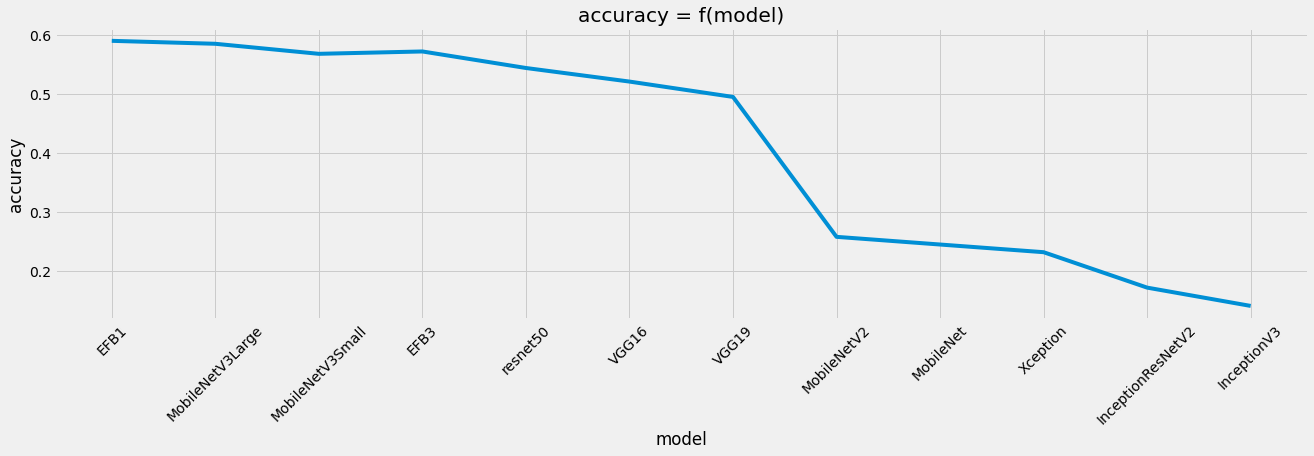

--------------------------------------------------avg_f1--------------------------------------------------


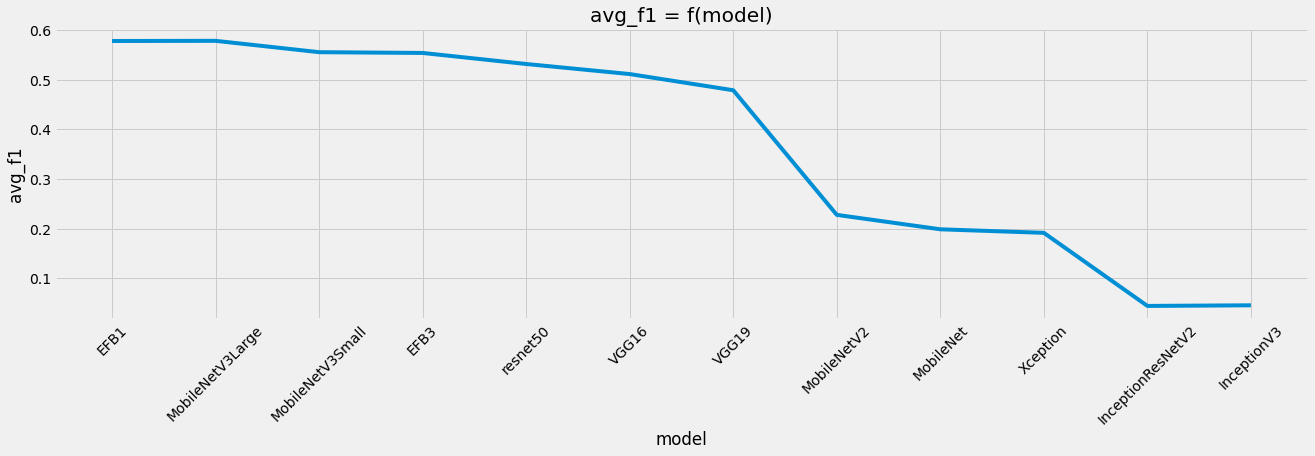

--------------------------------------------------wgt_avg_f1--------------------------------------------------


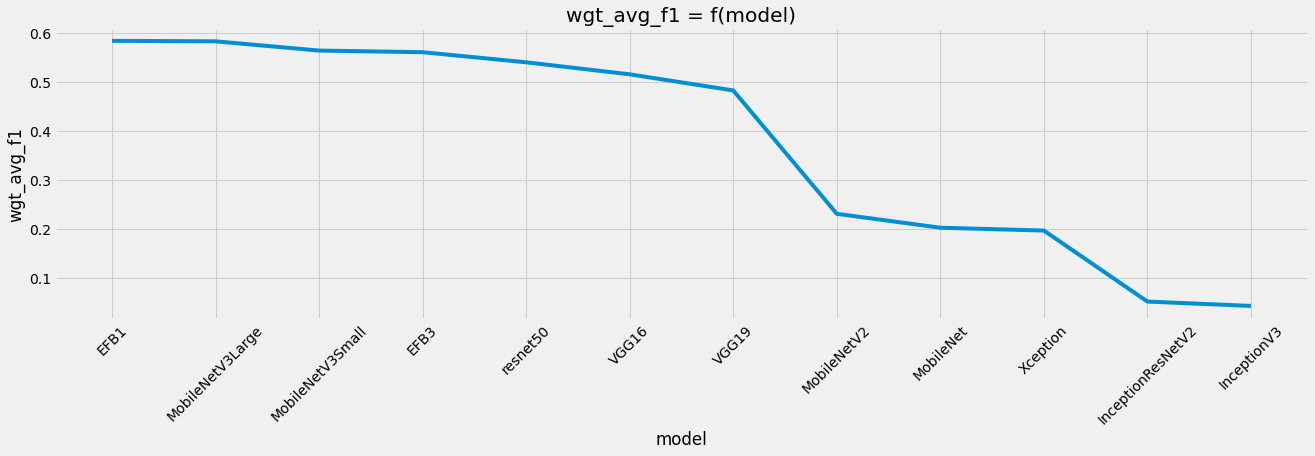

--------------------------------------------------fit_duration--------------------------------------------------


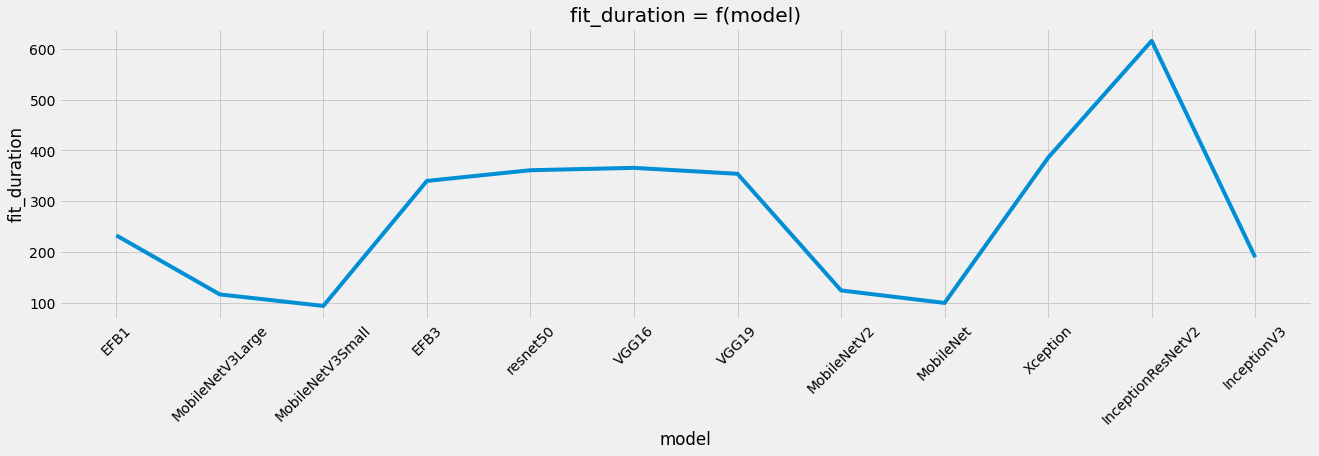

time: 928 ms (started: 2022-01-28 16:55:54 +00:00)


In [287]:
# /!\ a modifier si plusieurs models 
for metric in ['accuracy', 'avg_f1','wgt_avg_f1','fit_duration']:
    print('-'*50 + metric + '-'*50)
    fig = plot_perf(perf_summary,metric)
    display(fig)

### Top 3 history curves

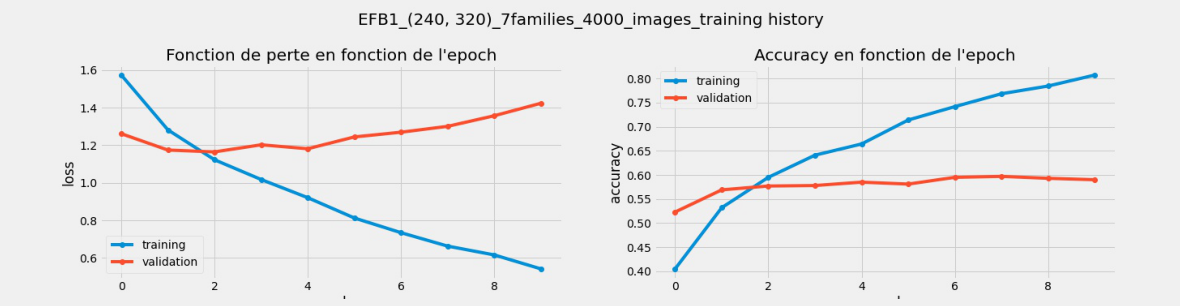

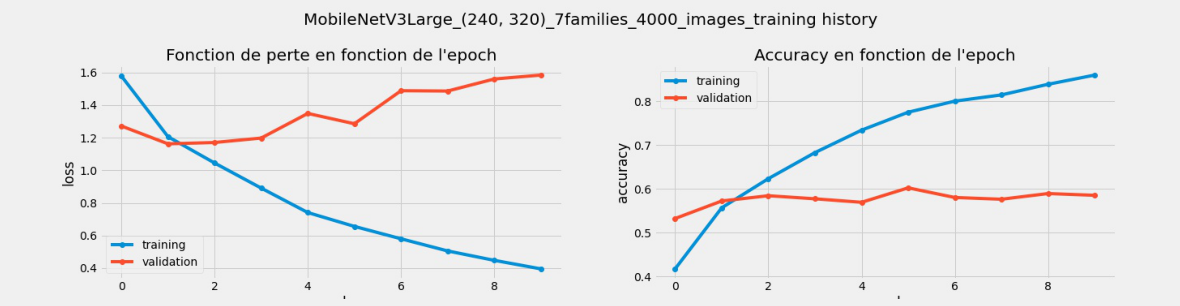

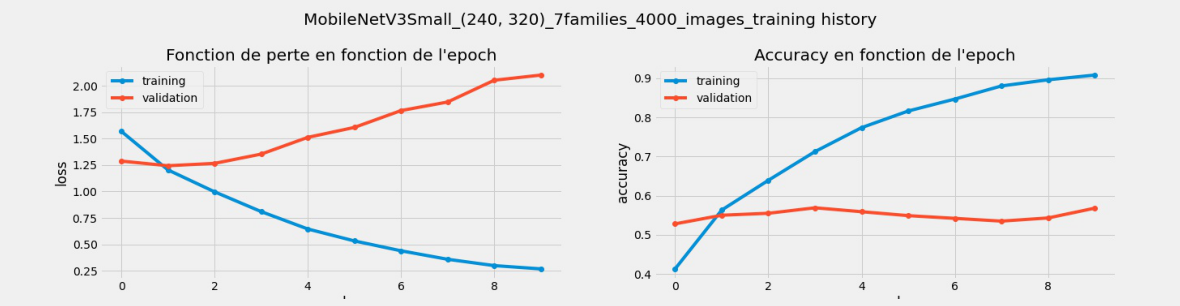

time: 735 ms (started: 2022-01-28 17:06:30 +00:00)


In [308]:
top_3 = perf_summary['model'][:3].values
for model in top_3:
  jpeg_name = model + '_(240, 320)_7families_4000_images_training_history.jpeg'
  jpeg_path = perf_report_dir + '/' + jpeg_name
  fig = plt.figure(figsize=(20,5))
  img = io.imread(jpeg_path)
  plt.axis('off')  
  plt.imshow(img)

### Top 3 confusion matrix

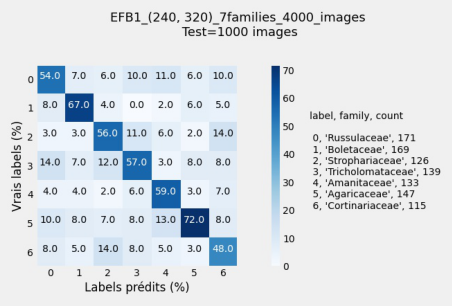

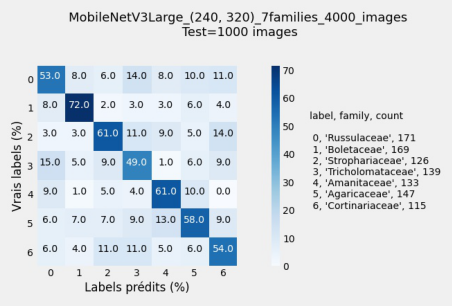

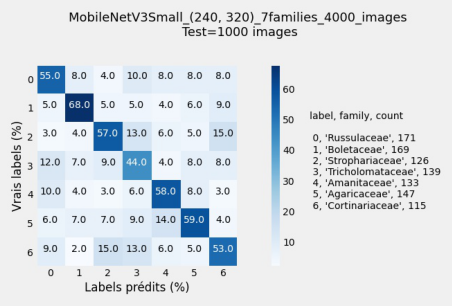

time: 643 ms (started: 2022-01-28 17:07:40 +00:00)


In [309]:
top_3 = perf_summary['model'][:3].values
for model in top_3:
  jpeg_name = model + '_(240, 320)_7families_4000_images_conf_matrix.jpeg'
  jpeg_path = perf_report_dir + '/' + jpeg_name
  fig = plt.figure(figsize=(20,5))
  img = io.imread(jpeg_path)
  plt.axis('off')  
  plt.imshow(img)

# TO DO
* random selct plot tf + train : 1 image per class
  * https://support.datascientest.com/t/8-retrouver-image-dans-le-tf-dataset/4033/4
* callbacks sur metric ? 
  * https://github.com/thibaultkaczmarek/MushPy/blob/main/models/iteration_2/20210623_model_effnet-datagenerator_unfreeze_GPU_colab.ipynb
* REVOIR COMMENT CHARGER LES DATA 
* ajouter randomc classes OTHER with images not in selctected cat ? 
  top-13-machine-learning-image-classification-datasets-all-pbm/
* model plus complexe https://github.com/thibaultkaczmarek/MushPy/blob/main/models/iteration_1/20210707_model_VGG16-datagenerator_GPU_mac.ipynb
* DOE training  with optuna and différents modèles 
* oversampling 
* optuna sur hyperparama:
  * https://danielvanstrien.xyz/hyperparameter%20optimisation/optimisation/optuna/fastai2/transfer%20learning/2020/07/01/optuna.html
  * https://colab.research.google.com/github/davanstrien/blog/blob/master/_notebooks/2020-07-01-optuna.ipynb
  * https://medium.com/@Minyus86/optkeras-112bcc34ec73
  * https://machinelearningapplied.com/hyperparameter-search-and-pruning-with-optuna-part-5-keras-cnn-classification-and-ensembling/
  * https://machinelearningapplied.com/hyperparameter-search-and-pruning-with-optuna-part-5-keras-cnn-classification-and-ensembling/


In [233]:
# !kill -9 -1

time: 534 µs (started: 2022-01-28 15:28:01 +00:00)
